[link text](https://)  
#  series 3 : Language Model Performance assessment (Real data)

## Setup

In [3]:
!pip install "tensorflow-text>=2.10"
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import typing
from typing import Any, Tuple
from sklearn.model_selection import train_test_split

import pathlib

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

#### Loading the Dataset

In [6]:
import pandas as pd
ORM_data = pd.read_csv('om-exp.csv')


In [7]:
ORM_data.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...","moduleOM_name:0,openDeclarationonesigclass1_na..."
1,"moduleOM_name:0,openDeclarationonesigclass1_na...","moduleOM_name:0,openDeclarationonesigclass1_na..."
2,"moduleOM_name:0,openDeclarationonesigclass1_na...","moduleOM_name:0,openDeclarationonesigclass1_na..."
3,"moduleOM_name:0,openDeclarationonesigclass1_na...","moduleOM_name:0,openDeclarationonesigclass1_na..."
4,"moduleOM_name:0,openDeclarationonesigclass1_na...","moduleOM_name:0,openDeclarationonesigclass1_na..."


In [8]:
OM_Regular = ORM_data['OM_Regular'].values
OM_Prediction = ORM_data['OM_Prediction'].values

In [9]:
X = OM_Regular
Y = OM_Prediction

#### Dividing data as Target and Context

In [10]:
target_raw =  Y
context_raw = X
print(context_raw[-1])

moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_a

In [11]:
print(target_raw[-1])

moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_a

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [12]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 1

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [13]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor([b'moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_a

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation, We may or may not decide to Use this for ORM data. I kept it in the experiment

In [14]:
example_text = tf.constant('moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_typeonesigc6_at4extendsc6_at4_typeonesigassoc1extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc2extendsAssociationsrc=class1_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc3extendsAssociationsrc=class4_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc}onesigassoc4extendsAssociationsrc=class1_namedst=class6_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}onesigassoc5extendsAssociationsrc=class1_namedst=class3_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc2}predshowrunshowfor38,​OM_name_Solution:0Table:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class1_nameAttributec1_at2:c1_at2_typeTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at2:c2_at2_typeTable:class2_nameAttributec2_at3:c2_at3_typeTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class3_nameAttributec3_at4:c3_at4_typeTable:class3_nameAttributec3_at2:c3_at2_typeTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class5_nameAttributec5_at3:c5_at3_typeTable:class5_nameAttributec5_at4:c5_at4_typeTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTable:class6_nameAttributec6_at2:c6_at2_typeTable:class6_nameAttributec6_at3:c6_at3_typeTable:class6_nameAttributec6_at4:c6_at4_typeTable:class1_nameAttributec1_at1:c1_at1_typePrimaryKeyTable:class2_nameAttributec2_at1:c1_at1_typePrimaryKeyTable:class3_nameAttributec3_at1:c3_at1_typePrimaryKeyTable:class4_nameAttributec4_at1:c4_at1_typePrimaryKeyTable:class6_nameAttributec6_at1:c6_at1_typePrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameMappingStrategyofTableclass1_name:map_str2MappingStrategyofTableclass2_name:map_str2MappingStrategyofTableclass3_name:map_str2MappingStrategyofTableclass4_name:map_str2MappingStrategyofTableclass6_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type1AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc4:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name0----CREATETABLE`assoc1`(`c5_at1`c5_at1_type`c1_at1`c1_at1_typeKEY`FK_assoc1_c5_at1_idx`(`c5_at1`)KEY`FK_assoc1_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c5_at1``c1_at1`));----CREATETABLE`assoc3``c5_at1`c5_at1_type`c4_at1`c4_at1_typeKEY`FK_assoc3_c5_at1_idx`(`c5_at1`)KEY`FK_assoc3_c4_at1_idx`(`c4_at1`)PRIMARYKEY(`c5_at1``c4_at1`));----CREATETABLE`class5_name`(`c5_at4`c5_at4_type(64)`c5_at3`c5_at3_type(64)`c1_at1`c1_at1_type`c5_at1`c5_at1_typePRIMARYKEY(`c5_at1`));----CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c3_at4`c3_at4_type`c3_at1`c3_at1_typeNOTNULLPRIMARYKEY(`c3_at1`));----CREATETABLE`class2_name`(`c2_at3`c2_at3_type(64)`c2_at2`c2_at2_type(64)`c2_at4`c2_at4_type`c2_at1`c2_at1_typePRIMARYKEY(`c2_at1`));----CREATETABLE`class4_name`(`c4_at1`c4_at1_typePRIMARYKEY(`c4_at1`));----CREATETABLE`class1_name`(`c1_at2`c1_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`));----CREATETABLE`class6_name`(`c6_at4`c6_at4_type`c6_at3`c6_at3_type`c6_at2`c6_at2_type`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`));----CREATETABLE`assoc2`(`c5_at1`c5_at1_type`c2_at1`c2_at1_typeKEY`FK_assoc2_c5_at1_idx`(`c5_at1`)KEY`FK_assoc2_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c5_at1``c2_at1`));----CREATETABLE`assoc5`(`c3_at1`c3_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c3_at1``c2_at1`));----CREATETABLE`assoc4`(`c6_at1`c6_at1_typeNOTNULL`c2_at1`c2_at1_typeKEY`FK_assoc4_c6_at1_idx`(`c6_at1`)KEY`FK_assoc4_c2_at1_idx`(`c2_at1`)PRIMARYKEY(`c6_at1``c2_at1`));ALTERTABLE`assoc1`ADDCONSTRAINT`FK_assoc1_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc1_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc2`ADDCONSTRAINT`FK_assoc2_c5_at1`FOREIGNKEY(`c5_at1`)REFERENCES`class5_name`(`c5_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc2_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADEALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE;ALTERTABLE`assoc4`ADDCONSTRAINT`FK_assoc4_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc4_c2_at1`FOREIGNKEY(`c2_at1`)REFERENCES`class2_name`(`c2_at1`)ONDELETECASCADEONUPDATECASCADE')

#example_text = tf.constant('class1,table2,obj1,atr1')
print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparen

In [15]:
#import re

#def tf_lower_and_split_punct(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  #text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  #pattern = '\s+'
  #re.split(pattern, text, maxsplit=2)
  #text = tf.strings.regex_replace(text, '\s+', '')
  #tf.strings.split(text, sep=', ', maxsplit=2, name=None)
  #tf.strings.split (text, sep='\s+', maxsplit=2, name=None)
  #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  #tf.strings.split(text, ',')
  #text = tf.strings.split(text, sep=None, maxsplit=-1, name=None)
  #text.tf.strings.split(', ')

  # Add spaces around punctuation.
  #text = tf.strings.regex_replace(text, '', r'')
  # Strip whitespace.
  #text = tf.strings.strip(text)

  #text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  #return text


def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '', r'\0')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [16]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

moduleOM_nameopenDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2_at1+c2_at2+c2_at3+c2_at4id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigc2_at3extendsc2_at3_typeonesigc2_at4extendsc2_at4_typeonesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigclass4_nameextendsClassattrSet=c4_at1id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigclass5_nameextendsClassattrSet=c5_at1+c5_at2+c5_at3+c5_at4id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigc5_at3extendsc5_at3_typeonesigc5_at4extendsc5_at4_typeonesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3+c6_at4id=c6_at1noparenti

#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [17]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [18]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:50]

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_name:0,opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsclassattrset=c2_at1oneparentparentinclass5_nameid=c3_at1isabstract=no}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsclassattrset=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsclassattrset=c4_at1+c4_at2id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsclassattrset=c5_at1+c3_at1id=c5_at1noparentisabstract=no}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6

That's the context data  `TextVectorization` layer, now build and `.adapt()` for the Target Data one:

In [19]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:50]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2ex

Now these layers can convert a batch of strings into a batch of token IDs:

In [20]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 51, 3]]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [21]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

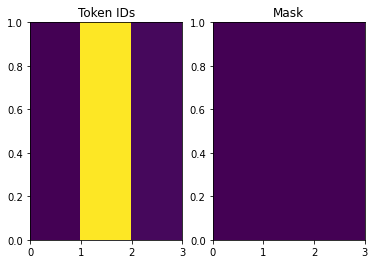

In [22]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [23]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [24]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[ 2 44  3]

[ 2 43]
[43  3]


## The encoder/decoder

  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [25]:
UNITS = 256

### The encoder


The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [27]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (1, 3)
Encoder output, shape (batch, s, units): (1, 3, 256)


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 


In [28]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [29]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (1, 3, 256)
Target sequence, shape (batch, t, units): (1, 2, 256)
Attention result, shape (batch, t, units): (1, 2, 256)
Attention weights, shape (batch, t, s):    (1, 2, 3)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [30]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1.], dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

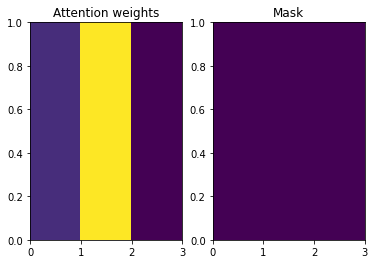

In [31]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.


Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [33]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [35]:
decoder = Decoder(target_text_processor, UNITS)

Decoder usage

In [36]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (1, 3, 256)
input target tokens shape: (batch, t) (1, 2)
logits shape shape: (batch, target_vocabulary_size) (1, 2, 80)


#### Inference

For inference usage couple more methods.

In [37]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [38]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [39]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [40]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3ex



```
# This is formatted as code
```

**Since the model's untrained, it outputs items from the vocabulary almost uniformly at random. **

## The model


In [41]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [42]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (1, 3)
Target tokens, shape: (batch, t) (1, 2)
logits, shape: (batch, t, target_vocabulary_size) (1, 2, 80)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [43]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [44]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [45]:
model.compile(optimizer='Adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [46]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 4.3820267, 'expected_acc': 0.0125}

That should roughly match the values returned by running a few steps of evaluation:

In [47]:
model.evaluate(val_ds, steps=40, return_dict=True)

16/40 [===========>..................] - ETA: 0s - loss: 4.0459 - masked_acc: 0.0312 - masked_loss: 4.0459

40/40 [==============================] - 9s 6ms/step - loss: 4.0221 - masked_acc: 0.0250 - masked_loss: 4.0221


{'loss': 4.022096157073975,
 'masked_acc': 0.02500000037252903,
 'masked_loss': 4.022096157073975}

In [48]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 40,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 3.0904 - masked_acc: 0.4900 - masked_loss: 3.0904

100/100 [==============================] - 19s 41ms/step - loss: 3.0904 - masked_acc: 0.4900 - masked_loss: 3.0904 - val_loss: 3.0462 - val_masked_acc: 0.5000 - val_masked_loss: 3.0462
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 2.4063 - masked_acc: 0.5300 - masked_loss: 2.4063

100/100 [==============================] - 4s 38ms/step - loss: 2.4063 - masked_acc: 0.5300 - masked_loss: 2.4063
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 1.6847 - masked_acc: 0.5657 - masked_loss: 1.6847

100/100 [==============================] - 4s 38ms/step - loss: 1.6800 - masked_acc: 0.5650 - masked_loss: 1.6800
Epoch 4/100
 99/100 [============================>.] - ETA: 0s - loss: 0.8473 - masked_acc: 0.7172 - masked_loss: 0.8473

100/100 [==============================] - 4s 38ms/step - loss: 0.8391 - masked_acc: 0.7200 - masked_loss: 0.8391
Epoch 5/100
100/100 [==============================] - ETA: 0s - loss: 0.2300 - masked_acc: 0.9600 - masked_loss: 0.2300

100/100 [==============================] - 4s 39ms/step - loss: 0.2300 - masked_acc: 0.9600 - masked_loss: 0.2300
Epoch 6/100
100/100 [==============================] - ETA: 0s - loss: 0.1087 - masked_acc: 0.9750 - masked_loss: 0.1087

100/100 [==============================] - 6s 60ms/step - loss: 0.1087 - masked_acc: 0.9750 - masked_loss: 0.1087
Epoch 7/100
100/100 [==============================] - ETA: 0s - loss: 0.0875 - masked_acc: 0.9750 - masked_loss: 0.0875

100/100 [==============================] - 4s 39ms/step - loss: 0.0875 - masked_acc: 0.9750 - masked_loss: 0.0875
Epoch 8/100
100/100 [==============================] - ETA: 0s - loss: 0.0471 - masked_acc: 0.9850 - masked_loss: 0.0471

100/100 [==============================] - 4s 38ms/step - loss: 0.0471 - masked_acc: 0.9850 - masked_loss: 0.0471
Epoch 9/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0608 - masked_acc: 0.9798 - masked_loss: 0.0608

100/100 [==============================] - 4s 39ms/step - loss: 0.0602 - masked_acc: 0.9800 - masked_loss: 0.0602
Epoch 10/100
100/100 [==============================] - ETA: 0s - loss: 0.0650 - masked_acc: 0.9750 - masked_loss: 0.0650

100/100 [==============================] - 4s 39ms/step - loss: 0.0650 - masked_acc: 0.9750 - masked_loss: 0.0650
Epoch 11/100
100/100 [==============================] - ETA: 0s - loss: 0.0506 - masked_acc: 0.9800 - masked_loss: 0.0506

100/100 [==============================] - 4s 39ms/step - loss: 0.0506 - masked_acc: 0.9800 - masked_loss: 0.0506
Epoch 12/100
100/100 [==============================] - ETA: 0s - loss: 0.0626 - masked_acc: 0.9800 - masked_loss: 0.0626

100/100 [==============================] - 4s 38ms/step - loss: 0.0626 - masked_acc: 0.9800 - masked_loss: 0.0626
Epoch 13/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0346 - masked_acc: 0.9848 - masked_loss: 0.0346

100/100 [==============================] - 4s 39ms/step - loss: 0.0343 - masked_acc: 0.9850 - masked_loss: 0.0343
Epoch 14/100
100/100 [==============================] - ETA: 0s - loss: 0.0445 - masked_acc: 0.9850 - masked_loss: 0.0445

100/100 [==============================] - 4s 38ms/step - loss: 0.0445 - masked_acc: 0.9850 - masked_loss: 0.0445
Epoch 15/100
100/100 [==============================] - ETA: 0s - loss: 0.0642 - masked_acc: 0.9800 - masked_loss: 0.0642

100/100 [==============================] - 4s 38ms/step - loss: 0.0642 - masked_acc: 0.9800 - masked_loss: 0.0642
Epoch 16/100
100/100 [==============================] - ETA: 0s - loss: 0.0441 - masked_acc: 0.9800 - masked_loss: 0.0441

100/100 [==============================] - 4s 38ms/step - loss: 0.0441 - masked_acc: 0.9800 - masked_loss: 0.0441
Epoch 17/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0357 - masked_acc: 0.9848 - masked_loss: 0.0357

100/100 [==============================] - 4s 38ms/step - loss: 0.0354 - masked_acc: 0.9850 - masked_loss: 0.0354
Epoch 18/100
100/100 [==============================] - ETA: 0s - loss: 0.0437 - masked_acc: 0.9800 - masked_loss: 0.0437

100/100 [==============================] - 6s 61ms/step - loss: 0.0437 - masked_acc: 0.9800 - masked_loss: 0.0437
Epoch 19/100
100/100 [==============================] - ETA: 0s - loss: 0.0375 - masked_acc: 0.9850 - masked_loss: 0.0375

100/100 [==============================] - 8s 82ms/step - loss: 0.0375 - masked_acc: 0.9850 - masked_loss: 0.0375
Epoch 20/100
100/100 [==============================] - ETA: 0s - loss: 0.0476 - masked_acc: 0.9800 - masked_loss: 0.0476

100/100 [==============================] - 5s 50ms/step - loss: 0.0476 - masked_acc: 0.9800 - masked_loss: 0.0476
Epoch 21/100
100/100 [==============================] - ETA: 0s - loss: 0.0342 - masked_acc: 0.9800 - masked_loss: 0.0342

100/100 [==============================] - 4s 39ms/step - loss: 0.0342 - masked_acc: 0.9800 - masked_loss: 0.0342
Epoch 22/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0457 - masked_acc: 0.9848 - masked_loss: 0.0457

100/100 [==============================] - 4s 39ms/step - loss: 0.0453 - masked_acc: 0.9850 - masked_loss: 0.0453
Epoch 23/100
100/100 [==============================] - ETA: 0s - loss: 0.0305 - masked_acc: 0.9850 - masked_loss: 0.0305

100/100 [==============================] - 7s 67ms/step - loss: 0.0305 - masked_acc: 0.9850 - masked_loss: 0.0305
Epoch 24/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0491 - masked_acc: 0.9798 - masked_loss: 0.0491

100/100 [==============================] - 4s 40ms/step - loss: 0.0486 - masked_acc: 0.9800 - masked_loss: 0.0486
Epoch 25/100
100/100 [==============================] - ETA: 0s - loss: 0.0418 - masked_acc: 0.9750 - masked_loss: 0.0418

100/100 [==============================] - 4s 38ms/step - loss: 0.0418 - masked_acc: 0.9750 - masked_loss: 0.0418
Epoch 26/100
100/100 [==============================] - ETA: 0s - loss: 0.0517 - masked_acc: 0.9700 - masked_loss: 0.0517

100/100 [==============================] - 4s 39ms/step - loss: 0.0517 - masked_acc: 0.9700 - masked_loss: 0.0517
Epoch 27/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0137 - masked_acc: 0.9949 - masked_loss: 0.0137

100/100 [==============================] - 4s 38ms/step - loss: 0.0268 - masked_acc: 0.9900 - masked_loss: 0.0268
Epoch 28/100
100/100 [==============================] - ETA: 0s - loss: 0.0418 - masked_acc: 0.9800 - masked_loss: 0.0418

100/100 [==============================] - 4s 39ms/step - loss: 0.0418 - masked_acc: 0.9800 - masked_loss: 0.0418
Epoch 29/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0343 - masked_acc: 0.9848 - masked_loss: 0.0343

100/100 [==============================] - 4s 39ms/step - loss: 0.0340 - masked_acc: 0.9850 - masked_loss: 0.0340
Epoch 30/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0372 - masked_acc: 0.9747 - masked_loss: 0.0372

100/100 [==============================] - 4s 38ms/step - loss: 0.0368 - masked_acc: 0.9750 - masked_loss: 0.0368
Epoch 31/100
100/100 [==============================] - ETA: 0s - loss: 0.0306 - masked_acc: 0.9850 - masked_loss: 0.0306

100/100 [==============================] - 4s 39ms/step - loss: 0.0306 - masked_acc: 0.9850 - masked_loss: 0.0306
Epoch 32/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0369 - masked_acc: 0.9848 - masked_loss: 0.0369

100/100 [==============================] - 4s 39ms/step - loss: 0.0366 - masked_acc: 0.9850 - masked_loss: 0.0366
Epoch 33/100
100/100 [==============================] - ETA: 0s - loss: 0.0277 - masked_acc: 0.9800 - masked_loss: 0.0277

100/100 [==============================] - 4s 39ms/step - loss: 0.0277 - masked_acc: 0.9800 - masked_loss: 0.0277
Epoch 34/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0250 - masked_acc: 0.9848 - masked_loss: 0.0250

100/100 [==============================] - 4s 38ms/step - loss: 0.0247 - masked_acc: 0.9850 - masked_loss: 0.0247
Epoch 35/100
100/100 [==============================] - ETA: 0s - loss: 0.0422 - masked_acc: 0.9750 - masked_loss: 0.0422

100/100 [==============================] - 4s 38ms/step - loss: 0.0422 - masked_acc: 0.9750 - masked_loss: 0.0422
Epoch 36/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0432 - masked_acc: 0.9747 - masked_loss: 0.0432

100/100 [==============================] - 4s 39ms/step - loss: 0.0428 - masked_acc: 0.9750 - masked_loss: 0.0428
Epoch 37/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0282 - masked_acc: 0.9899 - masked_loss: 0.0282

100/100 [==============================] - 4s 38ms/step - loss: 0.0279 - masked_acc: 0.9900 - masked_loss: 0.0279
Epoch 38/100
 99/100 [============================>.] - ETA: 0s - loss: 0.1238 - masked_acc: 0.9495 - masked_loss: 0.1238

100/100 [==============================] - 4s 39ms/step - loss: 0.1316 - masked_acc: 0.9450 - masked_loss: 0.1316
Epoch 39/100
 99/100 [============================>.] - ETA: 0s - loss: 2.4097 - masked_acc: 0.5556 - masked_loss: 2.4097

100/100 [==============================] - 4s 39ms/step - loss: 2.4233 - masked_acc: 0.5550 - masked_loss: 2.4233
Epoch 40/100
100/100 [==============================] - ETA: 0s - loss: 2.1051 - masked_acc: 0.5650 - masked_loss: 2.1051

100/100 [==============================] - 4s 39ms/step - loss: 2.1051 - masked_acc: 0.5650 - masked_loss: 2.1051
Epoch 41/100
100/100 [==============================] - ETA: 0s - loss: 0.8508 - masked_acc: 0.7250 - masked_loss: 0.8508

100/100 [==============================] - 4s 38ms/step - loss: 0.8508 - masked_acc: 0.7250 - masked_loss: 0.8508
Epoch 42/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2041 - masked_acc: 0.9444 - masked_loss: 0.2041

100/100 [==============================] - 4s 39ms/step - loss: 0.2024 - masked_acc: 0.9450 - masked_loss: 0.2024
Epoch 43/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0703 - masked_acc: 0.9798 - masked_loss: 0.0703

100/100 [==============================] - 4s 38ms/step - loss: 0.0696 - masked_acc: 0.9800 - masked_loss: 0.0696
Epoch 44/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0571 - masked_acc: 0.9798 - masked_loss: 0.0571

100/100 [==============================] - 5s 48ms/step - loss: 0.0566 - masked_acc: 0.9800 - masked_loss: 0.0566
Epoch 45/100
100/100 [==============================] - ETA: 0s - loss: 0.0381 - masked_acc: 0.9850 - masked_loss: 0.0381

100/100 [==============================] - 4s 38ms/step - loss: 0.0381 - masked_acc: 0.9850 - masked_loss: 0.0381
Epoch 46/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0356 - masked_acc: 0.9798 - masked_loss: 0.0356

100/100 [==============================] - 4s 39ms/step - loss: 0.0353 - masked_acc: 0.9800 - masked_loss: 0.0353
Epoch 47/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0492 - masked_acc: 0.9747 - masked_loss: 0.0492

100/100 [==============================] - 4s 40ms/step - loss: 0.0488 - masked_acc: 0.9750 - masked_loss: 0.0488
Epoch 48/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0418 - masked_acc: 0.9747 - masked_loss: 0.0418

100/100 [==============================] - 4s 39ms/step - loss: 0.0414 - masked_acc: 0.9750 - masked_loss: 0.0414
Epoch 49/100
100/100 [==============================] - ETA: 0s - loss: 0.0292 - masked_acc: 0.9900 - masked_loss: 0.0292

100/100 [==============================] - 4s 38ms/step - loss: 0.0292 - masked_acc: 0.9900 - masked_loss: 0.0292
Epoch 50/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0359 - masked_acc: 0.9798 - masked_loss: 0.0359

100/100 [==============================] - 4s 39ms/step - loss: 0.0356 - masked_acc: 0.9800 - masked_loss: 0.0356
Epoch 51/100
100/100 [==============================] - ETA: 0s - loss: 0.0355 - masked_acc: 0.9800 - masked_loss: 0.0355

100/100 [==============================] - 4s 39ms/step - loss: 0.0355 - masked_acc: 0.9800 - masked_loss: 0.0355
Epoch 52/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0380 - masked_acc: 0.9848 - masked_loss: 0.0380

100/100 [==============================] - 4s 38ms/step - loss: 0.0376 - masked_acc: 0.9850 - masked_loss: 0.0376
Epoch 53/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0363 - masked_acc: 0.9697 - masked_loss: 0.0363

100/100 [==============================] - 6s 58ms/step - loss: 0.0359 - masked_acc: 0.9700 - masked_loss: 0.0359
Epoch 54/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0192 - masked_acc: 0.9949 - masked_loss: 0.0192

100/100 [==============================] - 4s 39ms/step - loss: 0.0191 - masked_acc: 0.9950 - masked_loss: 0.0191
Epoch 55/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0468 - masked_acc: 0.9747 - masked_loss: 0.0468

100/100 [==============================] - 4s 39ms/step - loss: 0.0463 - masked_acc: 0.9750 - masked_loss: 0.0463
Epoch 56/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0345 - masked_acc: 0.9798 - masked_loss: 0.0345

100/100 [==============================] - 4s 40ms/step - loss: 0.0342 - masked_acc: 0.9800 - masked_loss: 0.0342
Epoch 57/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0295 - masked_acc: 0.9899 - masked_loss: 0.0295

100/100 [==============================] - 4s 40ms/step - loss: 0.0293 - masked_acc: 0.9900 - masked_loss: 0.0293
Epoch 58/100
100/100 [==============================] - ETA: 0s - loss: 0.0370 - masked_acc: 0.9750 - masked_loss: 0.0370

100/100 [==============================] - 4s 39ms/step - loss: 0.0370 - masked_acc: 0.9750 - masked_loss: 0.0370
Epoch 59/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - masked_acc: 0.9848 - masked_loss: 0.0306

100/100 [==============================] - 4s 39ms/step - loss: 0.0303 - masked_acc: 0.9850 - masked_loss: 0.0303
Epoch 60/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0341 - masked_acc: 0.9697 - masked_loss: 0.0341

100/100 [==============================] - 4s 39ms/step - loss: 0.0338 - masked_acc: 0.9700 - masked_loss: 0.0338
Epoch 61/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0262 - masked_acc: 0.9899 - masked_loss: 0.0262

100/100 [==============================] - 4s 38ms/step - loss: 0.0260 - masked_acc: 0.9900 - masked_loss: 0.0260
Epoch 62/100
100/100 [==============================] - ETA: 0s - loss: 0.0261 - masked_acc: 0.9900 - masked_loss: 0.0261

100/100 [==============================] - 4s 39ms/step - loss: 0.0261 - masked_acc: 0.9900 - masked_loss: 0.0261
Epoch 63/100
100/100 [==============================] - ETA: 0s - loss: 0.0306 - masked_acc: 0.9800 - masked_loss: 0.0306

100/100 [==============================] - 4s 39ms/step - loss: 0.0306 - masked_acc: 0.9800 - masked_loss: 0.0306
Epoch 64/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0369 - masked_acc: 0.9798 - masked_loss: 0.0369

100/100 [==============================] - 4s 40ms/step - loss: 0.0365 - masked_acc: 0.9800 - masked_loss: 0.0365
Epoch 65/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0297 - masked_acc: 0.9848 - masked_loss: 0.0297

100/100 [==============================] - 4s 39ms/step - loss: 0.0294 - masked_acc: 0.9850 - masked_loss: 0.0294
Epoch 66/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0306 - masked_acc: 0.9848 - masked_loss: 0.0306

100/100 [==============================] - 4s 38ms/step - loss: 0.0303 - masked_acc: 0.9850 - masked_loss: 0.0303
Epoch 67/100
100/100 [==============================] - ETA: 0s - loss: 0.0270 - masked_acc: 0.9900 - masked_loss: 0.0270

100/100 [==============================] - 4s 39ms/step - loss: 0.0270 - masked_acc: 0.9900 - masked_loss: 0.0270
Epoch 68/100
100/100 [==============================] - ETA: 0s - loss: 0.0319 - masked_acc: 0.9800 - masked_loss: 0.0319

100/100 [==============================] - 4s 39ms/step - loss: 0.0319 - masked_acc: 0.9800 - masked_loss: 0.0319
Epoch 69/100
100/100 [==============================] - ETA: 0s - loss: 0.0251 - masked_acc: 0.9850 - masked_loss: 0.0251

100/100 [==============================] - 6s 55ms/step - loss: 0.0251 - masked_acc: 0.9850 - masked_loss: 0.0251
Epoch 70/100
100/100 [==============================] - ETA: 0s - loss: 0.0299 - masked_acc: 0.9850 - masked_loss: 0.0299

100/100 [==============================] - 7s 66ms/step - loss: 0.0299 - masked_acc: 0.9850 - masked_loss: 0.0299
Epoch 71/100
100/100 [==============================] - ETA: 0s - loss: 0.0264 - masked_acc: 0.9850 - masked_loss: 0.0264

100/100 [==============================] - 4s 39ms/step - loss: 0.0264 - masked_acc: 0.9850 - masked_loss: 0.0264
Epoch 72/100
100/100 [==============================] - ETA: 0s - loss: 0.0315 - masked_acc: 0.9750 - masked_loss: 0.0315

100/100 [==============================] - 6s 55ms/step - loss: 0.0315 - masked_acc: 0.9750 - masked_loss: 0.0315
Epoch 73/100
100/100 [==============================] - ETA: 0s - loss: 0.0261 - masked_acc: 0.9850 - masked_loss: 0.0261

100/100 [==============================] - 5s 52ms/step - loss: 0.0261 - masked_acc: 0.9850 - masked_loss: 0.0261
Epoch 74/100
100/100 [==============================] - ETA: 0s - loss: 0.0379 - masked_acc: 0.9800 - masked_loss: 0.0379

100/100 [==============================] - 4s 39ms/step - loss: 0.0379 - masked_acc: 0.9800 - masked_loss: 0.0379
Epoch 75/100
100/100 [==============================] - ETA: 0s - loss: 0.0192 - masked_acc: 0.9900 - masked_loss: 0.0192

100/100 [==============================] - 4s 38ms/step - loss: 0.0192 - masked_acc: 0.9900 - masked_loss: 0.0192
Epoch 76/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0309 - masked_acc: 0.9899 - masked_loss: 0.0309

100/100 [==============================] - 4s 39ms/step - loss: 0.0360 - masked_acc: 0.9850 - masked_loss: 0.0360
Epoch 77/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0313 - masked_acc: 0.9798 - masked_loss: 0.0313

100/100 [==============================] - 4s 39ms/step - loss: 0.0310 - masked_acc: 0.9800 - masked_loss: 0.0310
Epoch 78/100
100/100 [==============================] - ETA: 0s - loss: 0.0215 - masked_acc: 0.9900 - masked_loss: 0.0215

100/100 [==============================] - 4s 39ms/step - loss: 0.0215 - masked_acc: 0.9900 - masked_loss: 0.0215
Epoch 79/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0370 - masked_acc: 0.9747 - masked_loss: 0.0370

100/100 [==============================] - 4s 39ms/step - loss: 0.0415 - masked_acc: 0.9700 - masked_loss: 0.0415
Epoch 80/100
100/100 [==============================] - ETA: 0s - loss: 0.0312 - masked_acc: 0.9850 - masked_loss: 0.0312

100/100 [==============================] - 4s 40ms/step - loss: 0.0312 - masked_acc: 0.9850 - masked_loss: 0.0312
Epoch 81/100
100/100 [==============================] - ETA: 0s - loss: 0.0261 - masked_acc: 0.9900 - masked_loss: 0.0261

100/100 [==============================] - 4s 40ms/step - loss: 0.0261 - masked_acc: 0.9900 - masked_loss: 0.0261
Epoch 82/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0267 - masked_acc: 0.9848 - masked_loss: 0.0267

100/100 [==============================] - 4s 39ms/step - loss: 0.0264 - masked_acc: 0.9850 - masked_loss: 0.0264
Epoch 83/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0304 - masked_acc: 0.9798 - masked_loss: 0.0304

100/100 [==============================] - 4s 38ms/step - loss: 0.0301 - masked_acc: 0.9800 - masked_loss: 0.0301
Epoch 84/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0330 - masked_acc: 0.9798 - masked_loss: 0.0330

100/100 [==============================] - 4s 39ms/step - loss: 0.0327 - masked_acc: 0.9800 - masked_loss: 0.0327
Epoch 85/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0210 - masked_acc: 0.9848 - masked_loss: 0.0210

100/100 [==============================] - 4s 39ms/step - loss: 0.0208 - masked_acc: 0.9850 - masked_loss: 0.0208
Epoch 86/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0319 - masked_acc: 0.9848 - masked_loss: 0.0319

100/100 [==============================] - 4s 39ms/step - loss: 0.0315 - masked_acc: 0.9850 - masked_loss: 0.0315
Epoch 87/100
100/100 [==============================] - ETA: 0s - loss: 0.0229 - masked_acc: 0.9900 - masked_loss: 0.0229

100/100 [==============================] - 4s 39ms/step - loss: 0.0229 - masked_acc: 0.9900 - masked_loss: 0.0229
Epoch 88/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0287 - masked_acc: 0.9848 - masked_loss: 0.0287

100/100 [==============================] - 4s 39ms/step - loss: 0.0284 - masked_acc: 0.9850 - masked_loss: 0.0284
Epoch 89/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0258 - masked_acc: 0.9798 - masked_loss: 0.0258

100/100 [==============================] - 4s 40ms/step - loss: 0.0255 - masked_acc: 0.9800 - masked_loss: 0.0255
Epoch 90/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0160 - masked_acc: 0.9899 - masked_loss: 0.0160

100/100 [==============================] - 4s 40ms/step - loss: 0.0158 - masked_acc: 0.9900 - masked_loss: 0.0158
Epoch 91/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0425 - masked_acc: 0.9747 - masked_loss: 0.0425

100/100 [==============================] - 4s 39ms/step - loss: 0.0444 - masked_acc: 0.9750 - masked_loss: 0.0444
Epoch 92/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0242 - masked_acc: 0.9848 - masked_loss: 0.0242

100/100 [==============================] - 4s 39ms/step - loss: 0.0240 - masked_acc: 0.9850 - masked_loss: 0.0240
Epoch 93/100
100/100 [==============================] - ETA: 0s - loss: 0.0511 - masked_acc: 0.9750 - masked_loss: 0.0511

100/100 [==============================] - 4s 39ms/step - loss: 0.0511 - masked_acc: 0.9750 - masked_loss: 0.0511
Epoch 94/100
 99/100 [============================>.] - ETA: 0s - loss: 0.7553 - masked_acc: 0.7929 - masked_loss: 0.7553

100/100 [==============================] - 4s 39ms/step - loss: 0.7874 - masked_acc: 0.7900 - masked_loss: 0.7874
Epoch 95/100
 99/100 [============================>.] - ETA: 0s - loss: 0.9423 - masked_acc: 0.7576 - masked_loss: 0.9423

100/100 [==============================] - 4s 39ms/step - loss: 0.9553 - masked_acc: 0.7550 - masked_loss: 0.9553
Epoch 96/100
 99/100 [============================>.] - ETA: 0s - loss: 0.2312 - masked_acc: 0.9040 - masked_loss: 0.2312

100/100 [==============================] - 4s 39ms/step - loss: 0.2293 - masked_acc: 0.9050 - masked_loss: 0.2293
Epoch 97/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0566 - masked_acc: 0.9747 - masked_loss: 0.0566

100/100 [==============================] - 4s 39ms/step - loss: 0.0561 - masked_acc: 0.9750 - masked_loss: 0.0561
Epoch 98/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0375 - masked_acc: 0.9848 - masked_loss: 0.0375

100/100 [==============================] - 4s 38ms/step - loss: 0.0371 - masked_acc: 0.9850 - masked_loss: 0.0371
Epoch 99/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0324 - masked_acc: 0.9848 - masked_loss: 0.0324

100/100 [==============================] - 4s 39ms/step - loss: 0.0356 - masked_acc: 0.9850 - masked_loss: 0.0356
Epoch 100/100
 99/100 [============================>.] - ETA: 0s - loss: 0.0390 - masked_acc: 0.9848 - masked_loss: 0.0390

100/100 [==============================] - 4s 40ms/step - loss: 0.0386 - masked_acc: 0.9850 - masked_loss: 0.0386


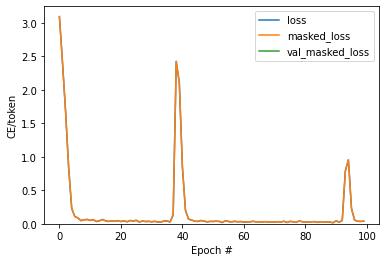

In [49]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['masked_loss'], label='masked_loss')
plt.plot(history.history['val_masked_loss'], label='val_masked_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

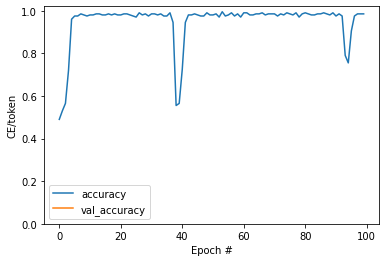

In [50]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [51]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [52]:
#sample Dataset Library_Management_Dataset_1_input_prerp_each_class_and_entitities_sep_experiment 



result1 = model.translate(['moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsClassattrSet=c5_at1+c3_at1id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigassoc1extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class6_namedst=Customersrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class3_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class3_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigCustomerLoanAssociationextendsAssociation{}{src=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}predshowrunshow​,Tableclass1_name:Attributec1_at1PrimaryKeyTableclass1_name:Attributec1_at2Tableclass2_name:Attributec2_at1PrimaryKeyTableclass3_name:Attributec3_at4Tableclass3_name:Attributec3_at5Tableclass3_name:Attributec3_at2Tableclass3_name:Attributec3_at2Tableclass4_name:Attributec4_at1PrimaryKeyTableclass4_name:Attributec4_at2Tableclass5_name:Attributec3_at1PrimaryKeyTableclass5_name:Attributec5_at1Tableclass6_name:Attributec6_at1PrimaryKeyTableclass6_name:Attributec6_at2Tableclass6_name:Attributec6_at3Tableclass7_name:Attributec7_at1Tableclass1_name:Attributec1_at1PrimaryKeyTableclass4_name:Attributec4_at1PrimaryKeyTableclass5_name:Attributec5_at1Tableclass6_name:Attributec6_at1PrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameTableName:class7_nameMappingStrategyforclass1_name:map_str2MappingStrategyforclass8_name:map_str2MappingStrategyforclass3_name:map_str2MappingStrategyforclass6_name:map_str2MappingStrategyforclass7_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name_0CREATETABLE`class5_name`(`c5_at1`c5_at1_typeNOTNULL`c3_at1`c3_at2_typeKEY`FK_class5_name_c3_at1_idx`(`c3_at1`)PRIMARYKEY(`c5_at1`),);CREATETABLE`class2_name`(`c7_at1`c7_at1_type`c5_at1`c5_at1_type`c3_at1`c3_at2_typePRIMARYKEY(`c3_at1`),);CREATETABLE`class6_name`(`c6_at3`c6_at3_type(64)`c6_at2`c6_at2_type(64)`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`),);CREATETABLE`class1_name`(`c1_at2`c4_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`),);CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c6_at1`c6_at1_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at1`c3_at2_typeKEY`FK_class3_name_c6_at1_idx`(`c6_at1`)PRIMARYKEY(`c3_at1`),);CREATETABLE`assoc5`(`c3_at1`c3_at2_type`c1_at1`c1_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`,`c1_at1`),);CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64)`c6_at1`c6_at1_type`c4_at1`c4_at1_typeNOTNULLKEY`FK_class4_name_c6_at1_idx`(`c6_at1`)PRIMARYKEY(`c4_at1`),);CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL`c3_at1`c3_at2_typeKEY`FK_assoc3_c4_at1_idx`(`c4_at1`)KEY`FK_assoc3_c3_at1_idx`(`c3_at1`)PRIMARYKEY(`c4_at1`,`c3_at1`),);CREATETABLE`class8_name`(`c5_at1`c5_at1_type`c3_at1`c3_at2_type`c2_at1`c2_at1_typePRIMARYKEY(`c3_at1`),);ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE'])


#result1[0].numpy().decode()
result1[0].numpy().decode()



'moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_

Use that to generate the attention plot:

In [53]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

In [54]:
#model.plot_attention('moduleOM_name:0,openDeclarationonesigclass1_nameextendsClassattrSet=c1_at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsClassattrSet=c2_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsClassattrSet=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsClassattrSet=c4_at1+c4_at2id=c4_at1noparentisAbstract=No}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsClassattrSet=c5_at1+c3_at1id=c5_at1noparentisAbstract=No}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstract=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nameextendsClassattrSet=c7_at1oneparentparentinclass5_nameid=c3_at1isAbstract=No}onesigc7_at1extendsc7_at1_type,onesigassoc1extendsAssociationsrc=class6_namedst=class4_name,src_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc2extendsAssociationsrc=class6_namedst=Customersrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigassoc3extendsAssociationsrc=class3_namedst=class4_name,src_multiplicity=src_mlpc2dst_multiplicity=dst_mlpc,}onesigassoc4extendsAssociationsrc=class3_namedst=class5_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}onesigCustomerLoanAssociationextendsAssociation{}{src=class3_namedst=class1_namesrc_multiplicity=src_mlpcdst_multiplicity=dst_mlpc,}predshowrunshow​,Tableclass1_name:Attributec1_at1PrimaryKeyTableclass1_name:Attributec1_at2Tableclass2_name:Attributec2_at1PrimaryKeyTableclass3_name:Attributec3_at4Tableclass3_name:Attributec3_at5Tableclass3_name:Attributec3_at2Tableclass3_name:Attributec3_at2Tableclass4_name:Attributec4_at1PrimaryKeyTableclass4_name:Attributec4_at2Tableclass5_name:Attributec3_at1PrimaryKeyTableclass5_name:Attributec5_at1Tableclass6_name:Attributec6_at1PrimaryKeyTableclass6_name:Attributec6_at2Tableclass6_name:Attributec6_at3Tableclass7_name:Attributec7_at1Tableclass1_name:Attributec1_at1PrimaryKeyTableclass4_name:Attributec4_at1PrimaryKeyTableclass5_name:Attributec5_at1Tableclass6_name:Attributec6_at1PrimaryKeyTableName:class1_nameTableName:class2_nameTableName:class3_nameTableName:class4_nameTableName:class5_nameTableName:class6_nameTableName:class7_nameMappingStrategyforclass1_name:map_str2MappingStrategyforclass8_name:map_str2MappingStrategyforclass3_name:map_str2MappingStrategyforclass6_name:map_str2MappingStrategyforclass7_name:map_str2AssociationStrategyforassoc1:assoc_type1AssociationStrategyforassoc2:assoc_type2AssociationStrategyforassoc3:assoc_type2AssociationStrategyforassoc5:assoc_type2,USEOM_name_0CREATETABLE`class5_name`(`c5_at1`c5_at1_typeNOTNULL`c3_at1`c3_at2_typeKEY`FK_class5_name_c3_at1_idx`(`c3_at1`)PRIMARYKEY(`c5_at1`),);CREATETABLE`class2_name`(`c7_at1`c7_at1_type`c5_at1`c5_at1_type`c3_at1`c3_at2_typePRIMARYKEY(`c3_at1`),);CREATETABLE`class6_name`(`c6_at3`c6_at3_type(64)`c6_at2`c6_at2_type(64)`c6_at1`c6_at1_typeNOTNULLPRIMARYKEY(`c6_at1`),);CREATETABLE`class1_name`(`c1_at2`c4_at2_type(64)`c1_at1`c1_at1_typePRIMARYKEY(`c1_at1`),);CREATETABLE`class3_name`(`c3_at3`c3_at3_type(64)`c3_at2`c3_at2_type(64)`c6_at1`c6_at1_type`c3_at5`c3_at5_type`c3_at4`c3_at4_type`c3_at1`c3_at2_typeKEY`FK_class3_name_c6_at1_idx`(`c6_at1`)PRIMARYKEY(`c3_at1`),);CREATETABLE`assoc5`(`c3_at1`c3_at2_type`c1_at1`c1_at1_typeKEY`FK_assoc5_c3_at1_idx`(`c3_at1`)KEY`FK_assoc5_c1_at1_idx`(`c1_at1`)PRIMARYKEY(`c3_at1`,`c1_at1`),);CREATETABLE`class4_name`(`c4_at2`c4_at2_type(64)`c6_at1`c6_at1_type`c4_at1`c4_at1_typeNOTNULLKEY`FK_class4_name_c6_at1_idx`(`c6_at1`)PRIMARYKEY(`c4_at1`),);CREATETABLE`assoc3`(`c4_at1`c4_at1_typeNOTNULL`c3_at1`c3_at2_typeKEY`FK_assoc3_c4_at1_idx`(`c4_at1`)KEY`FK_assoc3_c3_at1_idx`(`c3_at1`)PRIMARYKEY(`c4_at1`,`c3_at1`),);CREATETABLE`class8_name`(`c5_at1`c5_at1_type`c3_at1`c3_at2_type`c2_at1`c2_at1_typePRIMARYKEY(`c3_at1`),);ALTERTABLE`class5_name`ADDCONSTRAINT`FK_class5_name_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class3_name`ADDCONSTRAINT`FK_class3_name_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc5`ADDCONSTRAINT`FK_assoc5_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc5_c1_at1`FOREIGNKEY(`c1_at1`)REFERENCES`class1_name`(`c1_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`class4_name`ADDCONSTRAINT`FK_class4_name_c6_at1`FOREIGNKEY(`c6_at1`)REFERENCES`class6_name`(`c6_at1`)ONDELETECASCADEONUPDATECASCADE,ALTERTABLE`assoc3`ADDCONSTRAINT`FK_assoc3_c4_at1`FOREIGNKEY(`c4_at1`)REFERENCES`class4_name`(`c4_at1`)ONDELETECASCADEONUPDATECASCADEADDCONSTRAINT`FK_assoc3_c3_at1`FOREIGNKEY(`c3_at1`)REFERENCES`class3_name`(`c3_at1`)ONDELETECASCADEONUPDATECASCADE') # Are you still home

Translate a few more sentences and plot them:

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [55]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 moduleOM_name:0openDeclarationonesigclass1_nameextendsClassattrSet=c1_
at1+c1_at2id=c1_at1noparentisAbstract=No}onesigc1_at1extendsc1_at1_typ
eonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsClassattrSet=c2
_at1+c2_at2id=c2_at1noparentisAbstract=No}onesigc2_at1extendsc2_at1_ty
peonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsClassattrSet=c
3_at1+c3_at2id=c3_at1noparentisAbstract=No}onesigc3_at1extendsc3_at1_t
ypeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsClassattrSet=
c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisAbstract=No}onesigc4_at1
extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_
at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsClassatt
rSet=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isAbstract=No}o
nesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass
6_nameextendsClassattrSet=c6_at1+c6_at2+c6_at3id=c6_at1noparentisAbstr
act=No}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_

#Testing existing samples

In [56]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report

In [57]:
df = pd.read_csv('om-exp-testset.csv')

In [58]:
df.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",0


In [59]:
X_test = df['OM_Regular'].values
y_test = df['OM_Prediction'].values

In [60]:
print(X_test.shape)
print(y_test.shape)

print("\nX data type: ", X_test.dtype)
print("y data type: ", y_test.dtype)

(100,)
(100,)

X data type:  object
y data type:  int64


In [61]:
print (y_test)

[1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]


In [62]:
inputs = X_test

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [ ]:
#y_train_pred = model.predict(X_train)

In [63]:
%%time
for t in inputs:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_name:0,opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsclassattrset=c2_at1oneparentparentinclass5_nameid=c3_at1isabstract=no}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsclassattrset=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsclassattrset=c4_at1+c4_at2id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsclassattrset=c5_at1+c3_at1id=c5_at1noparentisabstract=no}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nam

# Classification Report (Existing samples)

In [64]:
dg = pd.read_csv('om-exp-prediction.csv')

In [65]:
X_test_pred = dg['OM_Regular'].values
y_test_pred = dg['OM_Prediction'].values

In [66]:
print (y_test_pred )

[1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0]


In [67]:
precision = precision_score(y_test, y_test_pred) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test, y_test_pred)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test, y_test_pred)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred))

Testing: Precision = 0.581395
Testing: Recall = 0.925926
Testing: F1 Score = 0.714286

Confusion Matrix (Test Data):
 [[55 18]
 [ 2 25]]


In [68]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.75      0.85        73
           1       0.58      0.93      0.71        27

    accuracy                           0.80       100
   macro avg       0.77      0.84      0.78       100
weighted avg       0.86      0.80      0.81       100



# Testing unseen samples

In [69]:
dc = pd.read_csv('om-exp-unseen.csv')

In [70]:
dc.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",0
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


In [71]:
X_test2 = df['OM_Regular'].values
y_test2 = df['OM_Prediction'].values

In [72]:
print(y_test2)

[1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1]


In [74]:
inputsi = X_test2

In [75]:
%%time
for t in inputsi:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_name:0,opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_type,onesigclass2_nameextendsclassattrset=c2_at1oneparentparentinclass5_nameid=c3_at1isabstract=no}onesigc2_at1extendsc2_at1_type,onesigclass3_nameextendsclassattrset=c3_at1+c3_at2+c3_at3+c3_at4+c3_at5id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at1extendsc3_at1_typeonesigc3_at3extendsc3_at3_typeonesigc3_at4extendsc3_at4_typeonesigc3_at5extendsc3_at5_type,onesigclass4_nameextendsclassattrset=c4_at1+c4_at2id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_type,onesigclass5_nameextendsclassattrset=c5_at1+c3_at1id=c5_at1noparentisabstract=no}onesigc5_at1extendsc5_at1_type,onesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_at3_type,onesigclass7_nam

# Classification Report (Unseen samples)


In [77]:
dd = pd.read_csv('om-exp-unseen-prediction.csv')

In [78]:
dd.head()

,OM_Regular,OM_Prediction
0,"moduleom_name:0,opendeclarationonesigclass1_na...",1
1,moduleom_name:0opendeclarationonesigclass1_nam...,1
2,moduleom_name:0opendeclarationonesigclass1_nam...,1
3,"moduleom_name:0,opendeclarationonesigclass1_na...",1
4,"moduleom_name:0,opendeclarationonesigclass1_na...",0


In [79]:
X_test_pred2 = dd['OM_Regular'].values
y_test_pred2 = dd['OM_Prediction'].values

In [80]:
print (y_test_pred2 )

[1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1
 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1]


In [81]:
precision = precision_score(y_test, y_test_pred2) 
print("Testing: Precision = %f" % precision)


recall = recall_score(y_test, y_test_pred2)
print("Testing: Recall = %f" % recall)


f1 = f1_score(y_test, y_test_pred2)
print("Testing: F1 Score = %f" % f1)

print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred2))

Testing: Precision = 0.634146
Testing: Recall = 0.962963
Testing: F1 Score = 0.764706

Confusion Matrix (Test Data):
 [[58 15]
 [ 1 26]]


In [82]:
print(classification_report(y_test,y_test_pred2))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88        73
           1       0.63      0.96      0.76        27

    accuracy                           0.84       100
   macro avg       0.81      0.88      0.82       100
weighted avg       0.89      0.84      0.85       100



# Testing unseen samples extended 





In [83]:
dx = pd.read_csv('om-exp-unseen-extended.csv')

In [84]:
dx.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",0
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


In [85]:
X_test3 = dx['OM_Regular'].values
y_test3 = dx['OM_Prediction'].values

In [86]:
print(y_test3)

[1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1]


In [87]:
inputg = X_test3

In [88]:
%%time
for t in inputg:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_a

#Classification Report (Unseen Extended samples)

In [89]:
dy = pd.read_csv('om-exp-unseen-extended-prediction.csv')

In [90]:
dy.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


In [91]:
X_test_pred3 = dy['OM_Regular'].values
y_test_pred3 = dy['OM_Prediction'].values

In [92]:
print (y_test_pred3)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 1]


In [94]:
#precision = precision_score(y_test, y_test_pred3) 
#print("Testing: Precision = %f" % precision)




##ValueError: Found input variables with inconsistent numbers of samples: [100, 108]

# Testing unseen samples under samples


In [95]:
dz = pd.read_csv('om-exp-unseen-undersample.csv')

In [96]:
dz.head()

,OM_Regular,OM_Prediction
0,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
1,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
2,"moduleOM_name:0,openDeclarationonesigclass1_na...",0
3,"moduleOM_name:0,openDeclarationonesigclass1_na...",1
4,"moduleOM_name:0,openDeclarationonesigclass1_na...",1


In [97]:
X_test4 = dz['OM_Regular'].values
y_test4 = dz['OM_Prediction'].values

In [98]:
print(y_test4)

[1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1]


In [99]:
inputop = X_test4

In [100]:
%%time
for t in inputop:
  #mylist_res = model.translate([t])[0].numpy().decode()
  print(model.translate([t])[0].numpy().decode())

print()

moduleom_name:0opendeclarationonesigclass1_nameextendsclassattrset=c1_at1+c1_at2id=c1_at1noparentisabstract=no}onesigc1_at1extendsc1_at1_typeonesigc1_at2extendsc1_at2_typeonesigclass2_nameextendsclassattrset=c2_at1+c2_at2id=c2_at1noparentisabstract=no}onesigc2_at1extendsc2_at1_typeonesigc2_at2extendsc2_at2_typeonesigclass3_nameextendsclassattrset=c3_at1+c3_at2id=c3_at1noparentisabstract=no}onesigc3_at1extendsc3_at1_typeonesigc3_at2extendsc3_at2_typeonesigclass4_nameextendsclassattrset=c4_at1+c4_at2+c4_at3+c4_at4id=c4_at1noparentisabstract=no}onesigc4_at1extendsc4_at1_typeonesigc4_at2extendsc4_at2_typeonesigc4_at3extendsc4_at3_typeonesigc4_at4extendsc4_at4_typeonesigclass5_nameextendsclassattrset=c5_at1+c5_at2oneparentparentinclass4_nameid=c4_at1isabstract=no}onesigc5_at1extendsc5_at1_typeonesigc5_at2extendsc5_at2_typeonesigclass6_nameextendsclassattrset=c6_at1+c6_at2+c6_at3id=c6_at1noparentisabstract=no}onesigc6_at1extendsc6_at1_typeonesigc6_at2extendsc6_at2_typeonesigc6_at3extendsc6_a